# Méthode pour détecter les séismes



In [7]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks
import os

Etape 1 : Ouvrir les données


In [8]:
cat_directory = '../data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

## Select a detection

In [9]:
row = cat.iloc[8]
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time

datetime.datetime(1970, 7, 20, 11, 44)

In [10]:
# If we want the value of relative time, we don't need to use datetime
arrival_time_rel = row['time_rel(sec)']
arrival_time_rel

42240.0

In [11]:
# Let's also get the name of the file
test_filename = row.filename
test_filename

'xa.s12.00.mhz.1970-07-20HR00_evid00011'

## Read the CSV file corresponding to that detection

We will now find the csv data file corresponding to that time and plot it!

In [12]:
data_directory = '../data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1970-07-20T00:00:00.487000,0.000000,-1.462155e-15
1,1970-07-20T00:00:00.637943,0.150943,-1.824771e-15
2,1970-07-20T00:00:00.788887,0.301887,-1.974266e-15
3,1970-07-20T00:00:00.939830,0.452830,-1.886487e-15
4,1970-07-20T00:00:01.090774,0.603774,-1.646714e-15
...,...,...,...
572406,1970-07-21T00:00:01.392660,86400.905660,-3.375389e-16
572407,1970-07-21T00:00:01.543604,86401.056604,-4.551111e-16
572408,1970-07-21T00:00:01.694547,86401.207547,-5.143100e-16
572409,1970-07-21T00:00:01.845491,86401.358491,-6.834513e-16


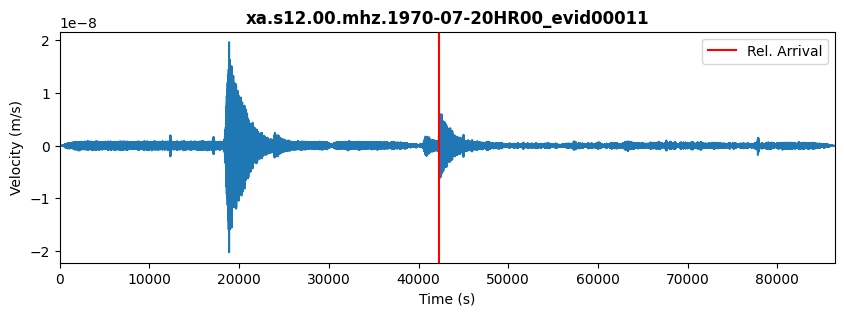

In [13]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

What if you wanted to plot in absolute time instead? The operations are very similar, just with a little extra datetime. It takes a bit longer, so we recommend working in relative time to start with!

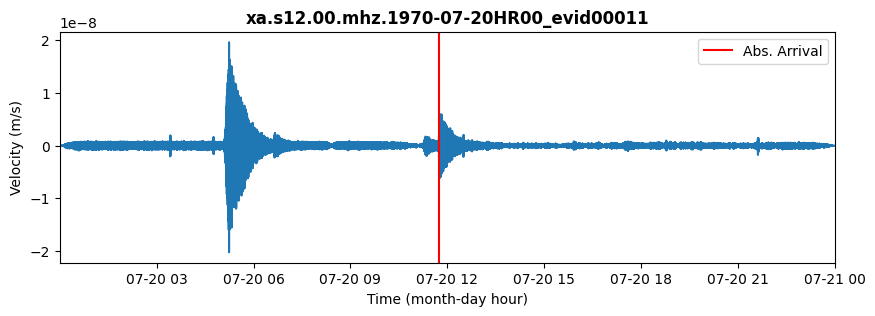

In [14]:
# Read in time steps and velocities
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))

csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times_dt,csv_data)

# Make the plot pretty
ax.set_xlim((np.min(csv_times_dt),np.max(csv_times_dt)))
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (month-day hour)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

### Alternatively: read the miniseed file corresponding to that detection

Same procedure as above, just using the miniseed file. 

In [15]:
data_directory = '../data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1970-07-20T00:00:00.487000Z - 1970-07-21T00:00:01.996434Z | 6.6 Hz, 572411 samples

In [16]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1970-07-20T00:00:00.487000Z
         endtime: 1970-07-21T00:00:01.996434Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572411
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [17]:
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
arrival

42239.513

### Plot the trace and mark the arrival! 

Use a similar method to plot the miniseed data and seismic arrival.

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-07-20HR00_evid00011')

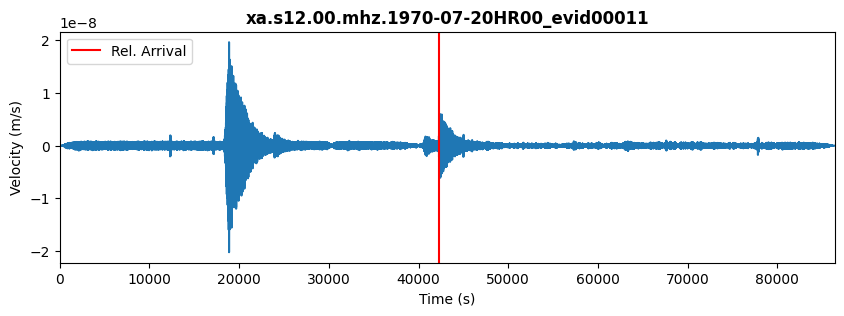

In [18]:
# Initialize figure
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times,tr_data)

# Mark detection
ax.axvline(x = arrival, color='red',label='Rel. Arrival')
ax.legend(loc='upper left')

# Make the plot pretty
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

There are multiple ways that we can do the absolute time using datetime, here is a simple way using the `.timedelta` method

Text(0.5, 1.0, 'xa.s12.00.mhz.1970-07-20HR00_evid00011')

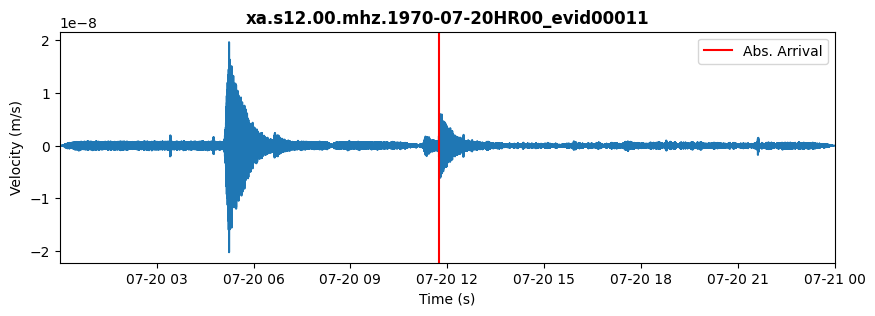

In [19]:
# Create a vector for the absolute time
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

# Plot the absolute result
fig,ax = plt.subplots(1,1,figsize=(10,3))

# Plot trace
ax.plot(tr_times_dt,tr_data)

# Mark detection
arrival_line = ax.axvline(x=arrival_time, c='red', label='Abs. Arrival')
ax.legend(handles=[arrival_line])

# Make the plot pretty
ax.set_xlim([min(tr_times_dt),max(tr_times_dt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')


It's completely up to you whether to work with the CSV file or the miniseed files. We recommend working with the miniseed file as it's a bit faster to run. 

## Let's filter the trace

Sometimes, it's useful to filter the trace to bring out particular frequencies. This will change the shape of the data and make it easier to see certain parts of the signal. In this example, we will filter the data using a bandpass filter between 0.01 Hz to 0.5 Hz. 

Largeur à mi-hauteur (FWHM) : 0.2974595613990647
Pourcentage basé sur la largeur à mi-hauteur : 35.47363045368594
Fréquence maximale : 0.8385371262956163 Hz
Amplitude maximale : 2.0798530996910268e-11


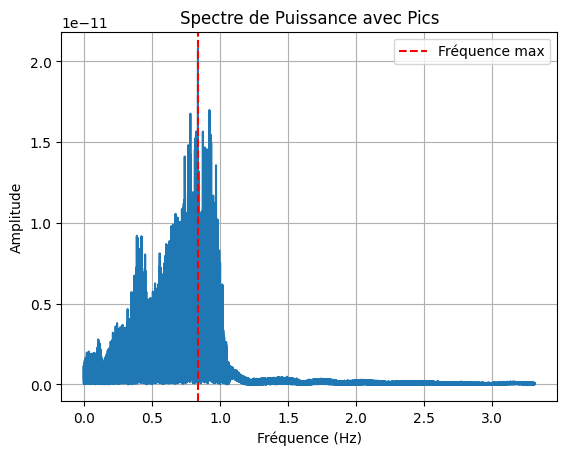

In [20]:
# Calculer la longueur des données et la période d'échantillonnage
n = len(tr.data)
sampling_rate = tr.stats.sampling_rate  # Obtenir la fréquence d'échantillonnage depuis l'objet trace
T = 1.0 / sampling_rate  # Période d'échantillonnage
x = np.linspace(0.0, n * T, n)

# 2. Calculer la FFT du signal
yf = fft(tr.data)

# 3. Calculer les fréquences correspondantes
xf = np.fft.fftfreq(n, T)[:n // 2]  # Fréquences positives

# 4. Calculer le spectre de puissance
spectrum = 2.0 / n * np.abs(yf[0:n // 2])  # Spectre de puissance (normalisé)

# 5. Trouver le maximum du spectre de puissance
max_index = np.argmax(spectrum)
max_frequency = xf[max_index]
max_amplitude = spectrum[max_index]

# 6. Calculer la largeur à mi-hauteur (FWHM)
half_max = max_amplitude / 2
indices_above_half_max = np.where(spectrum >= half_max)[0]
if len(indices_above_half_max) > 0:
    fwhm = xf[indices_above_half_max[-1]] - xf[indices_above_half_max[0]]
else:
    fwhm = 0  # Si aucune valeur ne dépasse la moitié de l'amplitude max

# 7. Calculer un pourcentage basé sur la largeur à mi-hauteur
percentage = (fwhm / max_frequency) * 100 if max_frequency != 0 else 5
if percentage == 0.0: 
    percentage = 5
print("Largeur à mi-hauteur (FWHM) :", fwhm)
print("Pourcentage basé sur la largeur à mi-hauteur :", percentage)


# 8. Afficher les résultats
print("Fréquence maximale :", max_frequency, "Hz")
print("Amplitude maximale :", max_amplitude)

# 9. Affichage des pics
plt.plot(xf, spectrum)
plt.title("Spectre de Puissance avec Pics")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.axvline(x=max_frequency, color='red', linestyle='--', label='Fréquence max')
plt.legend()
plt.show()


In [21]:
# Define the span of the bandpass filter
span = (( percentage ) /100) * max_frequency

# Set the minimum frequency
minfreq = max_frequency - span
maxfreq = max_frequency + span
print(minfreq, maxfreq)

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

0.001 1e-06


ValueError: Wn[0] must be less than Wn[1]

In [227]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

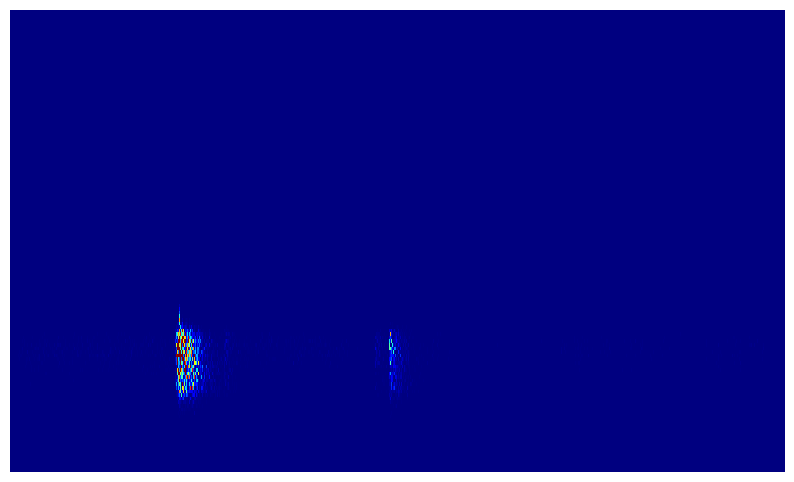

In [228]:
# Initialize the figure
fig = plt.figure(figsize=(10, 6))
file_name = f'{data_directory}{test_filename}.png'

# Spectrogram plot (without axes)
ax = plt.subplot(1, 1, 1)
vals = ax.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)

# Set axis limits
ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])

# Remove all the axes, ticks, and labels
ax.set_axis_off()

# Save the spectrogram without axes or labels
plt.savefig('spectrogram_{file_name}.png', dpi=300, bbox_inches='tight', pad_inches=0)

# Optional: Display the plot
plt.show()